In [ ]:
!pip install geopandas fiona shapely scipy matplotlib contextily folium

  Obtaining dependency information for geopandas from https://files.pythonhosted.org/packages/0b/70/d5cd0696eff08e62fdbdebe5b46527facb4e7220eabe0ac6225efab50168/geopandas-1.1.1-py3-none-any.whl.metadata
  Obtaining dependency information for fiona from https://files.pythonhosted.org/packages/65/0c/e8070b15c8303f60bd4444a120842597ccd6ed550548948e2e36cffbaa93/fiona-1.10.1-cp311-cp311-macosx_11_0_arm64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.0 MB/s eta 0:00:00
  Obtaining dependency information for shapely from https://files.pythonhosted.org/packages/4f/ce/28fab8c772ce5db23a0d86bf0adaee0c4c79d5ad1db766055fa3dab442e2/shapely-2.1.2-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for contextily from https://files.pythonhosted.org/packages/fb/46/07a029b73f9a5c7bbf9b538e6441c42014a448f335a1cc780616f2594bad/contextily-1.6.2-py3-none-any.whl.metadata
  Obtaining dependency information for pyogrio>=0.7.2 from https://files.pythonhost

In [ ]:
import geopandas as gpd
import fiona
from shapely.geometry import Point
import numpy as np
from scipy.spatial.distance import cdist
import random
import pandas as pd
import matplotlib.pyplot as plt

/Users/aylinkarapanar/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


*IMPORTANT: Before starting create an EU login and download urban atlas 2018 for utrecht*

In [31]:
gpkg_path = './NL004L3_UTRECHT_UA2018_v013/Data/NL004L3_UTRECHT_UA2018_v013.gpkg' 

In [32]:

green_codes = ['14100', '25000', '31000', '32000']
blue_codes = ['40000', '50000']

In [39]:
code_field = 'code_2018' 


In [34]:

layers = fiona.listlayers(gpkg_path)
for i, layer in enumerate(layers):
    print(f" {i}. {layer}")


 0. NL004L3_UTRECHT_UA2018
 1. NL004L3_UTRECHT_UA2018_Boundary
 2. NL004L3_UTRECHT_UA2018_UrbanCore


In [ ]:
try:
    sample_layer = layers[0]  
    gdf_sample = gpd.read_file(gpkg_path, layer=sample_layer)
    
    print(f"\nInspecting layer: '{sample_layer}'")
    print(f"\nColumns in this layer:")
    print(f"  {gdf_sample.columns.tolist()}")
    print(gdf_sample.head())
    
  
    print(f"Unique codes: {sorted(gdf_sample[code_field].unique())}")
   
except Exception as e:
    print(f"Error: {e}")



Inspecting layer: 'NL004L3_UTRECHT_UA2018'

Columns in this layer:
  ['country', 'fua_name', 'fua_code', 'code_2018', 'class_2018', 'prod_date', 'identifier', 'perimeter', 'area', 'comment', 'Pop2018', 'geometry']
  country fua_name fua_code code_2018  \
0      NL  Utrecht  NL004L3     31000   
1      NL  Utrecht  NL004L3     11100   
2      NL  Utrecht  NL004L3     11210   
3      NL  Utrecht  NL004L3     11210   
4      NL  Utrecht  NL004L3     11220   

                                          class_2018 prod_date     identifier  \
0                                            Forests   2020-02  18221-NL004L3   
1             Continuous urban fabric (S.L. : > 80%)   2020-02   1629-NL004L3   
2  Discontinuous dense urban fabric (S.L. : 50% -...   2020-02   3719-NL004L3   
3  Discontinuous dense urban fabric (S.L. : 50% -...   2020-02   3288-NL004L3   
4  Discontinuous medium density urban fabric (S.L...   2020-02   7265-NL004L3   

      perimeter          area comment  Pop2018  \
0

In [57]:
class SpatialSampler:
    def __init__(self, gpkg_path):
        self.gpkg_path = gpkg_path
        self.layers = fiona.listlayers(gpkg_path)
        
    def get_combined_features(self, layer_codes, code_field='code_2018'):
        """Load and combine features from multiple layers based on their codes."""
        all_features = []
        
        layer_name = self.layers[0]
        try:
            gdf = gpd.read_file(self.gpkg_path, layer=layer_name)
                
            
            if code_field in gdf.columns:
                filtered = gdf[gdf[code_field].isin(layer_codes)]
                if len(filtered) > 0:
                    filtered['source_layer'] = layer_name
                    all_features.append(filtered)
                    print(f" Layer '{layer_name}': found {len(filtered)} features")
            else:
                print(f" Layer '{layer_name}': '{code_field}' field not found")
        except Exception as e:
            print(f"  Layer '{layer_name}': Error - {e}")
        
        if not all_features:
            raise ValueError(f"No features found with codes {layer_codes}. Check your code_field name.")
        
        combined = gpd.GeoDataFrame(pd.concat(all_features, ignore_index=True))
        print(f"\nTotal features found: {len(combined)}")
        return combined
    
    def random_point_in_polygon(self, polygon, buffer_distance=5):
        """Generate a random point inside a polygon, away from borders."""
    
        buffered = polygon.buffer(-buffer_distance)
        
        if buffered.is_empty:
            buffered = polygon
        
        minx, miny, maxx, maxy = buffered.bounds
        max_attempts = 1000
        
        for _ in range(max_attempts):
            p = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
            if buffered.contains(p):
                return p
        
        return buffered.centroid
    
    def sample_points_with_constraints(self, gdf, n_samples, min_distance, 
                                      buffer_from_edge=5, max_attempts=10000):
        """Sample points from geodataframe with minimum distance constraint."""
        sampled_points = []
        sampled_coords = []
        attempts = 0
        
        print(f"Sampling {n_samples} points with constraints:")
        print(f"  Minimum distance: {min_distance}m")
        print(f"  Buffer from edges: {buffer_from_edge}m")
        print(f"  Total features available: {len(gdf)}")
        
        while len(sampled_points) < n_samples and attempts < max_attempts:
            attempts += 1
            
            # Randomly select a feature
            feature_idx = random.randint(0, len(gdf) - 1)
            feature = gdf.iloc[feature_idx]
            
            # Generate random point in the feature
            if feature.geometry.geom_type in ['Polygon', 'MultiPolygon']:
                if feature.geometry.geom_type == 'MultiPolygon':
                    polygons = list(feature.geometry.geoms)
                    polygon = max(polygons, key=lambda p: p.area)
                else:
                    polygon = feature.geometry
                
                new_point = self.random_point_in_polygon(polygon, buffer_from_edge)
            else:
                continue
            
            new_coords = np.array([[new_point.x, new_point.y]])
            
            # Check minimum distance constraint
            if sampled_coords:
                distances = cdist(new_coords, np.array(sampled_coords))
                if np.min(distances) < min_distance:
                    continue
            
            # Point is valid
            sampled_points.append({
                'point': new_point,
                'coords': (new_point.x, new_point.y),
                'feature_idx': feature_idx,
                'feature_info': feature.drop('geometry').to_dict()
            })
            sampled_coords.append([new_point.x, new_point.y])
            
            if len(sampled_points) % 10 == 0:
                print(f"  Progress: {len(sampled_points)}/{n_samples} points (attempts: {attempts})")
        
        if len(sampled_points) < n_samples:
            print(f" Only found {len(sampled_points)} valid points after {attempts} attempts")
            print(f"  Consider reducing min_distance or buffer_from_edge parameters")
        else:
            print(f"Successfully sampled {n_samples} points in {attempts} attempts")
        
        return sampled_points




In [58]:
# Initialize sampler
sampler = SpatialSampler(gpkg_path)


n_samples = 10 
min_distance = 1000  
buffer_from_edge = 1000

# Get combined features from target layers
gdf_combined = sampler.get_combined_features(green_codes, code_field="code_2018")

print(f"\nCombined GeoDataFrame info:")
print(f"  Total features: {len(gdf_combined)}")
print(f"  CRS: {gdf_combined.crs}")
print(f"  Bounds: {gdf_combined.total_bounds}")

# Sample points with constraints
sampled = sampler.sample_points_with_constraints(
    gdf_combined, 
    n_samples=n_samples,
    min_distance=min_distance,
    buffer_from_edge=buffer_from_edge
)

print(f"\n✓ Sampling complete! Generated {len(sampled)} points")



 Layer 'NL004L3_UTRECHT_UA2018': found 1494 features

Total features found: 1494

Combined GeoDataFrame info:
  Total features: 1494
  CRS: EPSG:3035
  Bounds: [3966537.2039     3211894.6077     4014136.72723759 3253093.036     ]
Sampling 10 points with constraints:
  Minimum distance: 1000m
  Buffer from edges: 1000m
  Total features available: 1494
  Progress: 10/10 points (attempts: 10)
Successfully sampled 10 points in 10 attempts

✓ Sampling complete! Generated 10 points


/Users/aylinkarapanar/anaconda3/lib/python3.11/site-packages/geopandas/geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [59]:
# %% Cell 8: Create GeoDataFrame from Sampled Points
# Convert sampled points to GeoDataFrame for easier handling
geometries = [s['point'] for s in sampled]
data = [s['feature_info'] for s in sampled]

samples_gdf = gpd.GeoDataFrame(data, geometry=geometries, crs=gdf_combined.crs)
samples_gdf['point_id'] = range(1, len(samples_gdf) + 1)

print("Sampled points GeoDataFrame:")
print(samples_gdf.head())
print(f"\nShape: {samples_gdf.shape}")



Sampled points GeoDataFrame:
  country fua_name fua_code code_2018         class_2018 prod_date  \
0      NL  Utrecht  NL004L3     14100  Green urban areas   2020-02   
1      NL  Utrecht  NL004L3     31000            Forests   2020-02   
2      NL  Utrecht  NL004L3     31000            Forests   2020-02   
3      NL  Utrecht  NL004L3     31000            Forests   2020-02   
4      NL  Utrecht  NL004L3     14100  Green urban areas   2020-02   

      identifier    perimeter          area comment  Pop2018  \
0  14967-NL004L3   211.412465   2844.533396    None        0   
1  18165-NL004L3   281.833451   4438.632786    None        0   
2  17831-NL004L3  1697.205770  33827.685926    None        0   
3  17818-NL004L3   967.974567  13933.392985    None        0   
4  14688-NL004L3   845.228520  21149.779949    None        0   

             source_layer                         geometry  point_id  
0  NL004L3_UTRECHT_UA2018  POINT (3986412.118 3229563.701)         1  
1  NL004L3_UTRECHT_UA20

/var/folders/8p/tfttmv8n3g34725p_r5jvgxc0000gn/T/ipykernel_80743/3486632247.py:16: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='best', fontsize=10)


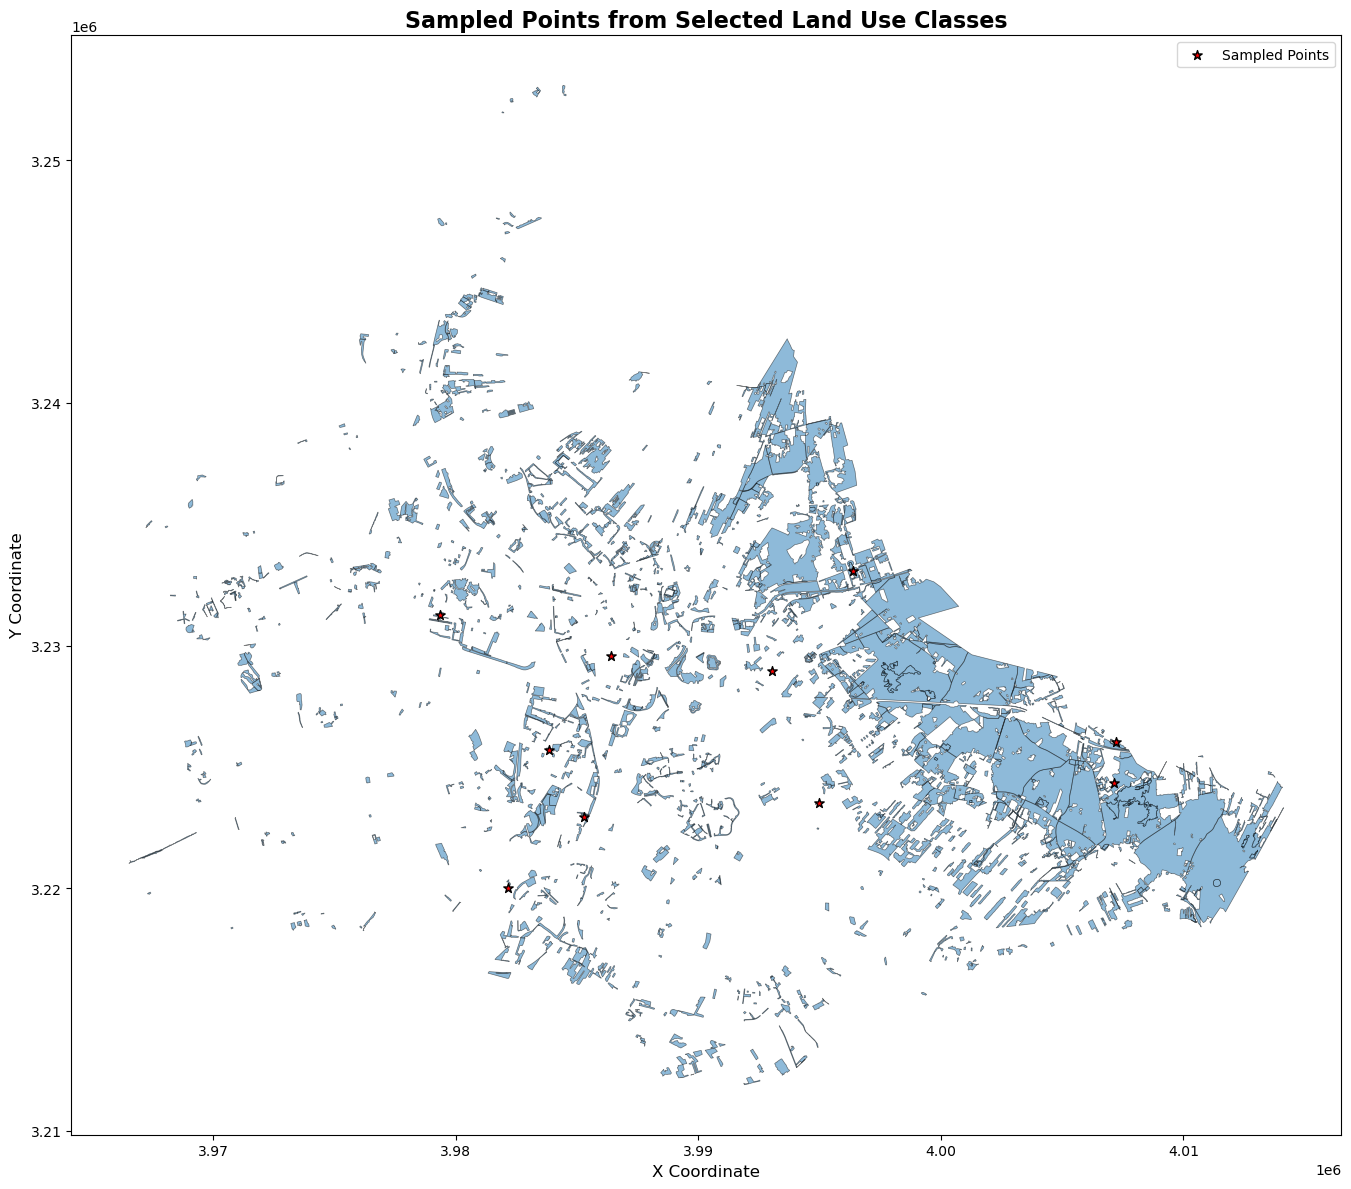

In [60]:
# %% Cell 9: Basic Visualization
# Plot the features and sampled points
fig, ax = plt.subplots(figsize=(15, 12))

# Plot all features by code (different colors for each land use class)
for code in green_codes:
    subset = gdf_combined[gdf_combined[code_field] == code]
    if len(subset) > 0:
        subset.plot(ax=ax, alpha=0.5, label=f'Code {code}', edgecolor='black', linewidth=0.5)

# Plot sampled points on top
samples_gdf.plot(ax=ax, color='red', markersize=50, marker='*', 
                 label='Sampled Points', edgecolor='black', linewidth=1, zorder=5)

ax.set_title('Sampled Points from Selected Land Use Classes', fontsize=16, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.set_xlabel('X Coordinate', fontsize=12)
ax.set_ylabel('Y Coordinate', fontsize=12)
plt.tight_layout()
plt.show()




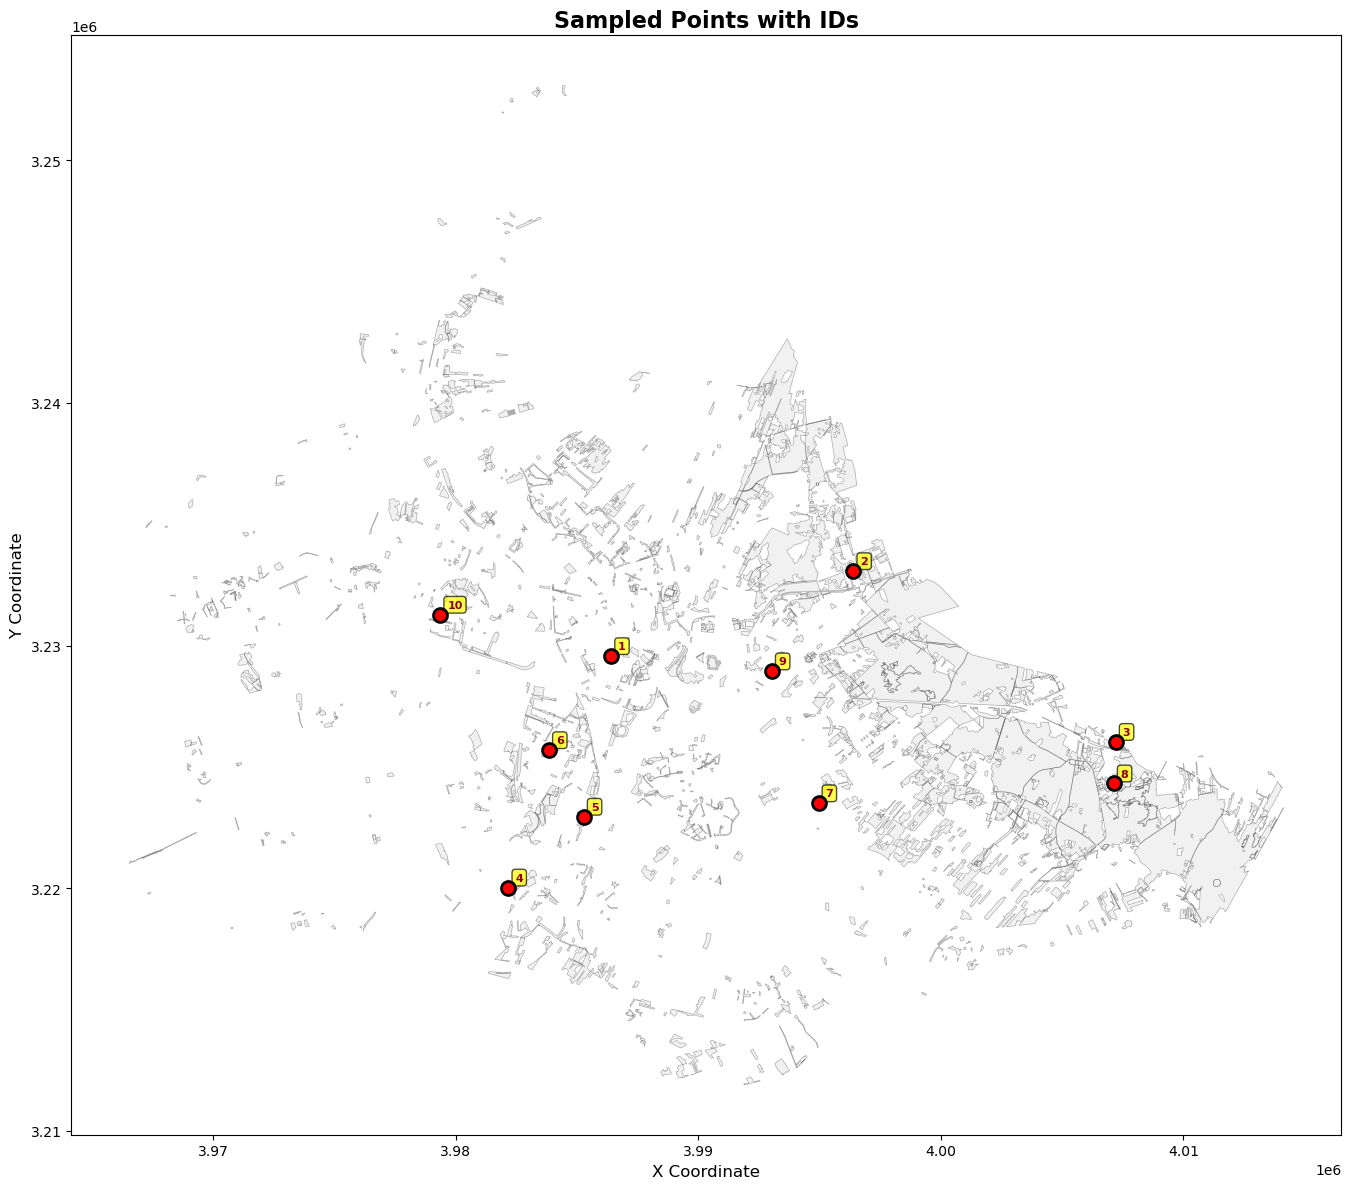

In [61]:
# %% Cell 10: Detailed Visualization with Point Labels
# Create a more detailed plot with point IDs
fig, ax = plt.subplots(figsize=(15, 12))

# Plot features
gdf_combined.plot(ax=ax, alpha=0.3, color='lightgray', edgecolor='black', linewidth=0.5)

# Plot sampled points
samples_gdf.plot(ax=ax, color='red', markersize=100, marker='o', 
                 edgecolor='black', linewidth=2, zorder=5)

# Add point ID labels
for idx, row in samples_gdf.iterrows():
    ax.annotate(text=str(row['point_id']), 
                xy=(row.geometry.x, row.geometry.y),
                xytext=(5, 5), textcoords='offset points',
                fontsize=8, color='darkred', fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

ax.set_title('Sampled Points with IDs', fontsize=16, fontweight='bold')
ax.set_xlabel('X Coordinate', fontsize=12)
ax.set_ylabel('Y Coordinate', fontsize=12)
plt.tight_layout()
plt.show()



/var/folders/8p/tfttmv8n3g34725p_r5jvgxc0000gn/T/ipykernel_80743/1123833654.py:30: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='best', fontsize=11, framealpha=0.9)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


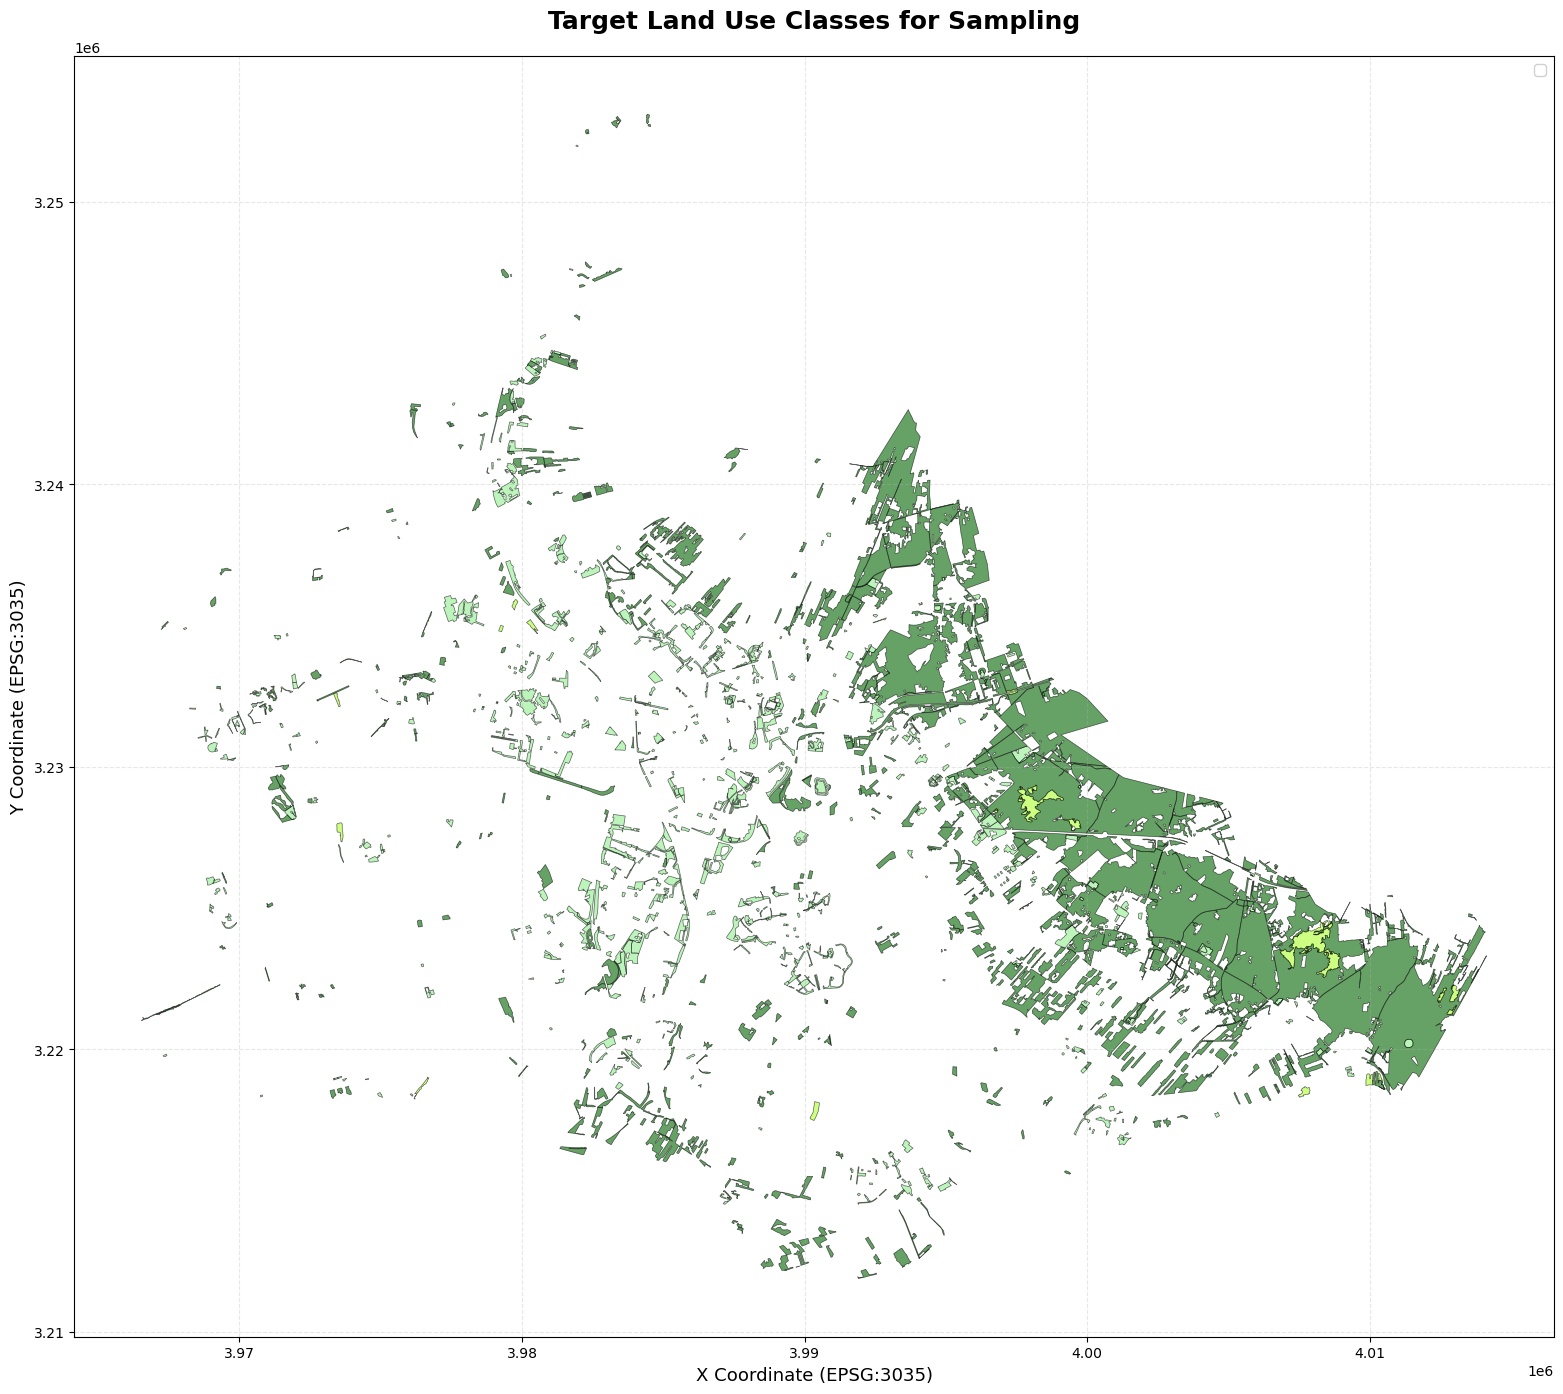

In [62]:
fig, ax = plt.subplots(figsize=(16, 14))

# Define colors for each code
color_map_green = {
    '14100': '#90EE90',  # Light green for green urban areas
    '31000': '#006400',  # Dark green for forests
    '32000': '#ADFF2F',  # Yellow-green for herbaceous vegetation
    '22000': '#FFD700',  # Gold for orchards/permanent crops
    '21000': '#F4A460',  # Sandy brown for arable land
}



# Plot each code with different color
for code in green_codes:
    subset = gdf_combined[gdf_combined[code_field] == code]
    if len(subset) > 0:
        # Get the class name for legend
        class_name = subset['class_2018'].iloc[0] if 'class_2018' in subset.columns else f'Code {code}'
        color = color_map_green.get(code, np.random.rand(3,))
        
        subset.plot(ax=ax, 
                   color=color, 
                   alpha=0.6, 
                   edgecolor='black', 
                   linewidth=0.5,
                   label=f'{code}: {class_name} (n={len(subset)})')

ax.set_title('Target Land Use Classes for Sampling', fontsize=18, fontweight='bold', pad=20)
ax.legend(loc='best', fontsize=11, framealpha=0.9)
ax.set_xlabel('X Coordinate (EPSG:3035)', fontsize=13)
ax.set_ylabel('Y Coordinate (EPSG:3035)', fontsize=13)
ax.grid(True, alpha=0.3, linestyle='--')


plt.tight_layout()
plt.show()


In [ ]:
#calculate area

if 'area' in stats_gdf.columns:
    total_area_km2 = stats_gdf['area'].sum() / 1_000_000
    print(f"Total area: {total_area_km2:.2f} km²")